> Code run locally due to server at 3.11 which is not supported by PyMOL



In [14]:
import os
from pathlib import Path
root = Path('/Users/user/Coding/EV-D68-3C-protease/')
os.chdir(root)

In [25]:
# NB. This is the Fragalysis download data
# this is for an asymmetric dimer but biological monomer

import pymol2
import chempy # from pymol installation
from pathlib import Path
from typing import List, Set, Dict, Tuple
import json

# ASSUMPTIONS: the PDBs have CONECT records. If not, use connect_mode = 1
# Fragalysis data is fine.
connect_mode = 0 # https://pymolwiki.org/index.php/Connect_mode

# data folder from Fragalysis download
folder = Path('download/D68EV3CPROA')
assert folder.exists()
fluff_marker = '§'  # name + fluff + index, say MPRO-x0102_0B§1
reference_chain = 'A'
skip_chains = []  # this is not the target protein, but a partner
lig_resn = 'LIG'

pdb_blocks: Dict[str, str] = {}
details: Dict[str, dict] = {}
for holo in (folder / Path('aligned')).glob('*/*.pdb'):
    #print(holo)
    with pymol2.PyMOL() as pymol:
        pymol.cmd.set('connect_mode',connect_mode)
        pymol.cmd.load('reference.pdb', 'ref')
        pymol_name = 'holo'
        pymol.cmd.load(str(holo.absolute()), pymol_name)
        # get info
        xstal_name: str = holo.name.rstrip('.pdb').rstrip('_bound').strip()
        xstal_info: pd.Series = metadata.set_index('crystal_name').loc[xstal_name]
        # ## Determine what is unique ligand residue
        # get atoms of ligand
        lig_atoms: List[chempy.Atom] = pymol.cmd.get_model(f'%{pymol_name} and resn {lig_resn}').atom
        # get set of tuple of resi chain segi alt
        selectors: Set[tuple] = {(atom.resi, atom.chain, atom.segi, atom.alt) for atom in lig_atoms}
        # iterate for all unique
        i = 0
        for resi, chain, segi, alt in selectors:
            sele = f'%{pymol_name} and resn {lig_resn} and resi {resi}'
            if chain:
                sele+= f' and chain {chain}'
            if segi:
                sele+= f' and segi {segi}'
            if alt:
                sele+= f' and alt {alt}'
            # figure out if it's in the wrong chain (asymmetric dimer)
            n_neigh = pymol.cmd.select('neighs', f'%{pymol_name} and polymer.protein and (byres {sele} around 4)')
            if not n_neigh:
                continue
            polymer_chains = pymol.cmd.get_chains('neighs')
            for polymer_chain in polymer_chains:
                if polymer_chain in skip_chains:
                    continue
                i += 1
                neoname = f'{xstal_name}{fluff_marker}{i}'
                pymol.cmd.align(f'%{pymol_name} and polymer.protein and chain {polymer_chain}',
                                 f'%ref and polymer.protein and chain {reference_chain}')
                pymol.cmd.create('copied', sele)
                pymol.cmd.alter('%copied', 'alt=""')
                pymol.cmd.alter('%copied', 'segi=""')
                pymol.cmd.alter('%copied', 'chain="X"')
                pymol.cmd.alter('%copied', 'resi="1"')
                pymol.cmd.sort()
                pdb_blocks[neoname] = pymol.cmd.get_pdbstr('%copied')
                pymol.cmd.delete('copied')
                details[neoname] = {**xstal_info.to_dict(),
                                    **dict(base_name=xstal_name,
                                        lig_resn=lig_resn,
                                         lig_resi=resi,
                                         lig_chain=chain,
                                         lig_segi=segi,
                                         lig_alt=alt,
                                         polymer_chain=polymer_chain,)
                                    }
            #pymol.cmd.create('modded', sele)
            #print(i, sele, n_neigh)

print('done')

done


In [27]:
[k for k in details if 'D68EV3CPROA-x1140' in k]

['D68EV3CPROA-x1140_0A§1']

In [28]:
from rdkit.Chem import Draw
from typing import List
from IPython.display import Image

def flatgrid(mols, *args, **kwargs) -> Image:
    copies: List[Chem.Mol] = [Chem.Mol(m) for m in mols]
    *map(AllChem.Compute2DCoords, copies),   # noqa, it's in place
    if 'legends' not in kwargs:
        kwargs['legends'] = [m.GetProp('_Name') if m.HasProp('_Name') else '-' for m in mols]
    return Draw.MolsToGridImage(copies, *args, **kwargs)

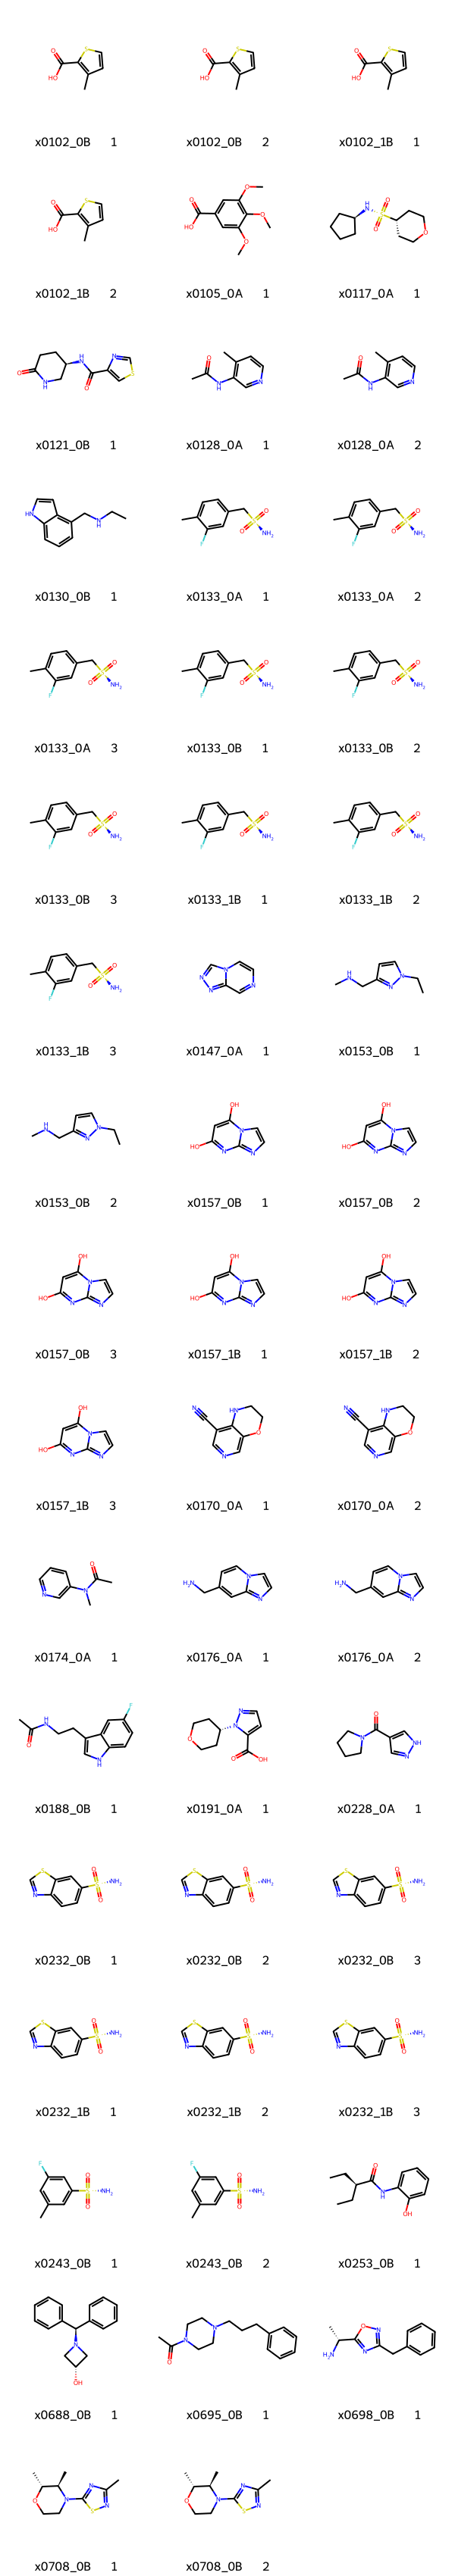

In [33]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import ipywidgets as widgets

smiles_col_name = 'single_smiles'

mols = []
baddies = []
for name, block in pdb_blocks.items():
    detail: dict = details[name]
    with widgets.Output():
        mol = Chem.MolFromPDBBlock(block, proximityBonding='CONECT' not in block)
        if mol is None:
            #print(f'Issue with sanitisation, trying without for {name}')
            mol = Chem.MolFromPDBBlock(block, proximityBonding='CONECT' not in block, sanitize=False)
    assert mol, f'{name} failed to load'
    assert mol.GetNumAtoms() > 0 and mol.GetNumBonds() > 0, f'{name} failed to load'
    ref = Chem.MolFromSmiles(detail[smiles_col_name])
    try:
        with widgets.Output():
            mol = AllChem.AssignBondOrdersFromTemplate(ref, mol)
    except Exception as e:
        print(f'Issue with bond orders for {name} - {e.__class__.__name__}{e}')
        baddies.append(dict(name=name, block=block, mol=mol, ref=ref, detail=detail, exception=e))
        continue
    mol.SetProp('XChem_code', name.split('_')[0])
    mol.SetProp('Occupancy', json.dumps([a.GetPDBResidueInfo().GetOccupancy() for a in mol.GetAtoms()]) )
    mol.SetProp('TempFactor', json.dumps([a.GetPDBResidueInfo().GetTempFactor() for a in mol.GetAtoms()]) )
    unprefixed = name.lstrip('D68EV3CPROA-')
    mol.SetProp('_Name', unprefixed)
    for k, v in detail.items():
        if isinstance(v, dict):
            v = json.dumps(v)
        mol.SetProp(k, str(v))
    for atom in mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        atom.SetProp('molFileAlias', name)
    mols.append(mol)

assert mols, 'No mols!'

flatgrid(sorted(mols, key=lambda mol: mol.GetProp('_Name')))

In [34]:
import operator

*map(operator.itemgetter('name'), baddies),

()

In [36]:
#baddies[0]['ref']

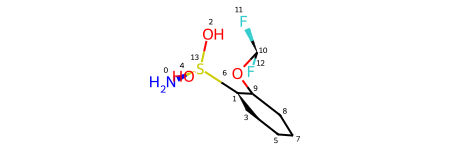

In [44]:
# error corrections based on failure of below...
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

baddies[0]['mol']

In [42]:
rwmol = Chem.RWMol(baddies[3]['mol'])
rwmol.RemoveBond(6, 12)
baddies[3]['mol'] = rwmol.GetMol()

In [48]:
## redux

for baddie in baddies:
    name = baddie['name']
    mol = AllChem.AssignBondOrdersFromTemplate(baddie['ref'], baddie['mol'])
    mol.SetProp('XChem_code', name.split('_')[0])
    mol.SetProp('Occupancy', json.dumps([a.GetPDBResidueInfo().GetOccupancy() for a in mol.GetAtoms()]) )
    mol.SetProp('TempFactor', json.dumps([a.GetPDBResidueInfo().GetTempFactor() for a in mol.GetAtoms()]) )
    unprefixed = name.lstrip('D68EV3CPROA-')
    mol.SetProp('_Name', unprefixed)
    for k, v in baddie['detail'].items():
        if isinstance(v, dict):
            v = json.dumps(v)
        mol.SetProp(k, str(v))
    for atom in mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        atom.SetProp('molFileAlias', name)
    mols.append(mol)

[12:15:25] WARNING: More than one matching pattern found - picking one

[12:15:25] WARNING: More than one matching pattern found - picking one

[12:15:25] WARNING: More than one matching pattern found - picking one

[12:15:25] WARNING: More than one matching pattern found - picking one



'D68EV3CPROA-x0133_1B§1'

In [37]:
# Save

with Chem.SDWriter('hits_redux.sdf') as sdf:
    for mol in mols:
        if mol is None:
            continue
        sdf.write(mol)

In [42]:
good_ids = ['x1052_0A§2', 'x1453_0B§2', 'x1498_0A§1', 'x0232_0B§3', 'x0771_1A§1', 'x0980_0B§1', 'x0147_0A§1', 'x1285_0B§2', 'x1498_1B§1', 'x1594_0A§1', 'x1537_0A§1', 'x1604_0A§1', 'x1498_0B§1', 'x0789_0A§1', 'x1285_1B§2', 'x1305_0B§1', 'x0232_1B§3', 'x0771_0A§1', 'x1083_0A§1', 'x1454_0B§1', 'x1247_0A§1', 'x1140_0A§1', 'x1052_1A§2', 'x1020_0A§1']

In [43]:
hitdex = {mol.GetProp('_Name'): mol for mol in mols}

In [46]:
x1594_analogues={'ZINC000000080837': 'Oc1nsc2ncccc12',
 'ZINC000000168472': 'Nc1noc2ncccc12',
 'ZINC000012397068': 'Cc1noc2ncc(N)cc12',
 'ZINC000015042097': 'Cc1nsc2ncccc12',
 'ZINC000017061891': 'Cc1noc2nc[nH]c(=O)c12',
 'ZINC000001669068': 'Nc1snc2ncccc12',
 'ZINC000001674121': 'Cc1noc2ncnc(N)c12',
 'ZINC000019779146': 'Cc1ccc2c(N)noc2n1',
 'ZINC000224485041': 'Nc1snc2nccnc12',
 'ZINC000238711097': 'Nc1snc2ncc(Br)cc12',
 'ZINC000025924635': 'Nc1noc2nccnc12',
 'ZINC000026033116': 'Nc1nnc2ncccn12',
 'ZINC000002289036': 'Nc1nnc2nccnn12',
 'ZINC000003852685': 'Brc1noc2ncccc12',
 'ZINC000039191805': 'Cc1nsc2nc[nH]c(=O)c12',
 'ZINC000045921422': 'Cc1noc2ncnc(Cl)c12',
 'ZINC000051951618': 'BrCc1noc2ncccc12',
 'ZINC000005933792': 'S=c1ssc2ncccc12',
 'ZINC000066323473': 'Cc1ccn2c(N)nnc2n1',
 'ZINC000066347860': 'Brc1nnc2ncccn12',
 'ZINC000072187487': 'Brc1nsc2nccnc12',
 'ZINC000072482101': 'Nc1nsc2ncccc12',
 'ZINC000079065151': 'Clc1nsc2ncccc12',
 'ZINC000082372119': 'Cc1nnc2ncc(Br)cn12',
 'ZINC000082372152': 'Cc1noc2ncc(Br)cc12',
 'ZINC000095830806': 'Nc1noc2ncc(Br)cc12'}

In [94]:
waters = []

for m in AllChem.GetMolFrags(Chem.MolFromPDBFile('waters.pdb'), asMols = True):
    resi = m.GetAtomWithIdx(0).GetPDBResidueInfo().GetResidueNumber()
    if resi == 164:
        m.SetProp('_Name', f'oxyanionHOH')
    elif resi == 83:
        m.SetProp('_Name', f'trappedHOH')
    else:
        m.SetProp('_Name', f'HOH{resi}')
    waters.append(m)

In [98]:
with Chem.SDMolSupplier('trimmed_x0771-x1604.sdf') as sdfh:
    trimmed = list(sdfh)

In [ ]:
from fragmenstein import Monster

# 'Nc1n[nH]c2ccccc12' --> '[Se]c1p[pH]c2ccccc12'
aminoindazole = monstah.place_smiles('[Se]c1p[pH]c2ccccc12').positioned_mol
aminoindazole.SetProp('_Name', 'aminoindazole')
x1594_mols = []
for zid in x1594_analogues:
    monstah = Monster([aminoindazole])
    mol = monstah.place_smiles(x1594_analogues[zid]).positioned_mol
    mol.SetProp('_Name', zid)
    mol.SetProp('inspiration', 'x1594')
    x1594_mols.append(mol)

In [113]:
fipped_sulfonamide = Monster([hitdex['x1140_0A§1']]).place_smiles('NS(=O)(=O)C', custom_map={'x1140_0A§1': {0: 0, 15: 1, 2: 4, 3: 3, 4: 2}}).positioned_mol
fipped_sulfonamide.SetProp('_Name','fippedSulfonamide')

Provided mapping is very unfavourable... using that along for expanding the search
[18:30:32] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:32] Molecule does not have explicit Hs. Consider calling AddHs()


In [115]:
with Chem.SDWriter('hits.filtered.sdf') as sdfh:
    for identifier in good_ids:
        sdfh.write(hitdex[identifier])
    for mol in x1594_mols:
        sdfh.write(mol)
    for trim in trimmed:
        sdfh.write(trim)
    sdfh.write(fipped_sulfonamide)
    for water in waters:
        sdfh.write(water)

['x1247_0A§1']


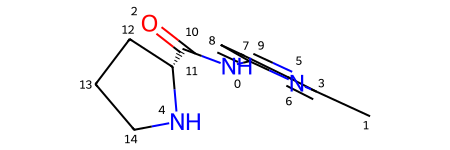

In [127]:
code = 'x1247'

options = [n for n in hitdex if code in n]
print(options)
hitdex[options[0]]